In [1]:
import itertools

import numpy as np
import pandas as pd
import tensorflow as tf
from keras.metrics import Precision, Recall, AUC, CategoricalAccuracy

from tensorflow.keras import backend as K
from custom_models.cnns import simple_cnn_bn
from custom_models.augmentation import basic_augmentation, basic_plus_color_augmentation
from custom_models.optimization_utilities import get_standard_callbacks
from etl.load_dataset import DatasetProcessor, get_tf_eggim_patch_dataset
import os

2024-08-17 14:42:01.819311: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 14:42:01.819384: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 14:42:01.819413: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-17 14:42:01.827067: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
target_dir = '../../../test_files/EGGIMazing/Dataset'
model_weights_directory = '../../../logs/'
batch_size = 32
num_epochs = 100
learning_rate = 1e-4
num_folds = 5
name = f'cnn_binary_9_1{num_folds}'
model_fold_dir = sorted(os.listdir(model_weights_directory))
model_dirs = [os.path.join(os.path.join(model_weights_directory, x), 'weights.h5')
              for x in model_fold_dir if x.startswith(name)]

In [5]:
model_dirs

['../../../logs/cnn_binary_9_15fold_0_20240816-152421/weights.h5',
 '../../../logs/cnn_binary_9_15fold_1_20240816-152510/weights.h5',
 '../../../logs/cnn_binary_9_15fold_2_20240816-152600/weights.h5',
 '../../../logs/cnn_binary_9_15fold_3_20240816-152647/weights.h5',
 '../../../logs/cnn_binary_9_15fold_4_20240816-152733/weights.h5']

In [6]:
n_classes = 2  # Replace with the number of classes you have
dp = DatasetProcessor(target_dir)
df = dp.process(merge_eggim_square=True)

togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)
df_ipo = df[~togas_ids_boolean].reset_index(drop=True)

split = dp.smarter_multiple_ds_group_k_splits(df_togas,
                                              df_ipo,
                                              k=num_folds,
                                              train_size=0.9,
                                              test_size=0.1,
                                              internal_train_size=0.5,
                                              random_state=42)

y_preds = []
y_trues = []
for fold, (df_train, df_val, df_test) in enumerate(split):
    model = simple_cnn_bn(input_shape=(224, 224, 3), n_classes=n_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall'),
                               AUC(name='auc')])

    name_fold = name + f'fold_{fold}'
    checkpoint_dir, callbacks = get_standard_callbacks(name_fold, learning_rate)
    tf_test_df = get_tf_eggim_patch_dataset(df_test, num_classes=n_classes)
    tf_test_df = tf_test_df.batch(batch_size)
    # around 70 no class weight
    model.load_weights(model_dirs[fold])
    model.evaluate(tf_test_df)
    y_preds.append(model.predict(tf_test_df))
    y_trues.append(np.concatenate([y for (_, y) in tf_test_df]))

2024-08-17 14:42:42.917330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-17 14:42:42.917620: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-17 14:42:42.922550: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

1/1 [==============================] - 0s 119ms/step


In [7]:
from evaluation.metrics import specificity_per_class
from evaluation.metrics import sensitivity_per_class
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
metrics = []
for y_true, y_pred in zip(y_trues, y_preds):
    y_pred = [1 if y_ > 0.5 else 0 for y_ in y_pred ]
    conf_matrix = confusion_matrix(y_true, y_pred)

    metrics.append([accuracy_score(y_true, y_pred),
                    balanced_accuracy_score(y_true, y_pred),
                    sensitivity_per_class(conf_matrix),
                    specificity_per_class(conf_matrix),
                    conf_matrix])

In [8]:
acc = np.array([x[0] for x in metrics])
bal_acc = np.array([x[1] for x in metrics])
spec = np.array([x[2] for x in metrics])
sens = np.array([x[3] for x in metrics])
confs = np.array([x[4] for x in metrics])

In [9]:
acc, bal_acc, np.mean(sens,axis=1)

(array([0.81481481, 0.93103448, 0.76666667, 0.80645161, 0.83333333]),
 array([0.9       , 0.94117647, 0.75837321, 0.79059829, 0.9       ]),
 array([0.9       , 0.94117647, 0.75837321, 0.79059829, 0.9       ]))

/tmp/ipykernel_3325402/1032877647.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Acc.', 'Bal Acc.'])


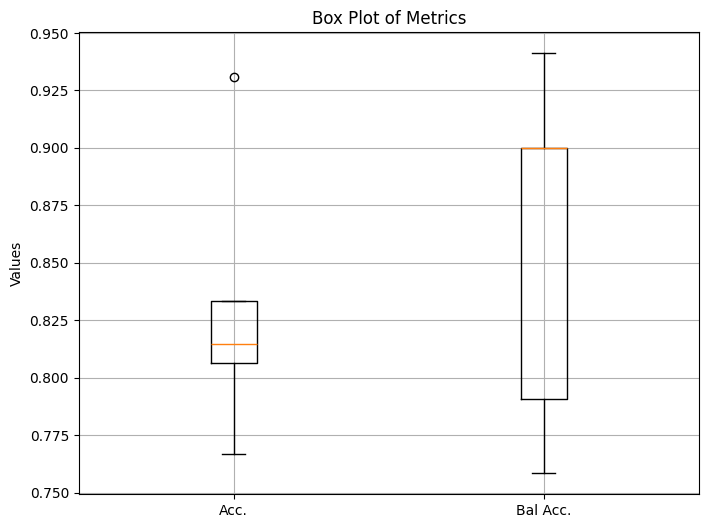

In [10]:
import matplotlib.pyplot as plt
data = [acc, bal_acc]

# Create the box plot
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=['Acc.', 'Bal Acc.'])
plt.title('Box Plot of Metrics')
plt.ylabel('Values')
plt.grid(True)

# Show the plot
plt.show()